# Setup

In [17]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [18]:
%matplotlib inline

In [19]:
from relaxed.plot_defaults import *

In [20]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings
from tqdm import tqdm

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [21]:
from relaxed.analysis import get_mah, add_box_indices, get_tt_indices, get_alpha
from relaxed.models import training_suite
from relaxed import halo_catalogs


# Data

In [22]:
mah_data = get_mah('m12', '../../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [23]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
eta = cat['eta']
spin = cat['spin']
voff = cat['v0']

q = cat['q']
ma = mah_data['ma']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']


## Alpha Fit 

In [9]:
# alpha parametrization fit MAH
# m(a) = exp(- alpha * z)
alphas  = [] 
for ii in tqdm(range(len(ma))):
    lam_ii = np.log(ma)[ii]
    alpha = get_alpha(1 /scales - 1, lam_ii)
    alphas.append(alpha)
alphas = np.array(alphas)
ma_exp  = np.exp(- alphas * (1/ scales - 1 ))
am_exp = (1 - (1/alphas * np.log(mass_bins)))**-1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:26<00:00, 115.62it/s]


## Train and Test set

In [10]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

In [11]:
# train/test split
train_idx, test_idx = get_tt_indices(len(cat), test_ratio=0.3)
cvir_train, xoff_train, eta_train, voff_train, q_train, spin_train, alpha_train = (cvir[train_idx], 
                                                           xoff[train_idx], eta[train_idx], voff[train_idx], q[train_idx], spin[train_idx], alphas[train_idx])
cvir_test, xoff_test, eta_test, voff_test, q_test, spin_test, alpha_test = (cvir[test_idx], 
                                                     xoff[test_idx], eta[test_idx], voff[test_idx], q[test_idx], spin[test_idx], alphas[test_idx])


# Train

In [12]:
# joint models
y_train = np.hstack([cvir_train.reshape(-1, 1), eta_train.reshape(-1, 1), xoff_train.reshape(-1, 1), 
                     spin_train.reshape(-1, 1), q_train.reshape(-1, 1)])
data ={
    'multi_gaussian_alpha': {
        'xy': (alpha_train, y_train), 'n_features': 1, 'n_targets': 5, 'model': 'gaussian',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    }, 
}
joint_models = training_suite(data)

(array([9.350e+02, 1.902e+03, 1.450e+02, 1.100e+01, 3.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.01379073,  7.65827271, 14.30275469, 20.94723667, 27.59171865,
        34.23620063, 40.88068261, 47.52516459, 54.16964657, 60.81412855,
        67.45861053]),
 [<matplotlib.patches.Polygon at 0x7fb02b6a14c0>])

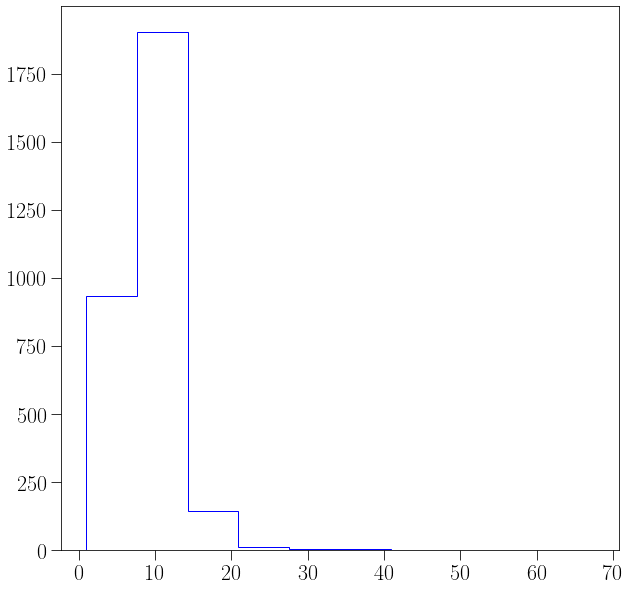

In [13]:
samples = joint_models['multi_gaussian_alpha'].sample(alpha_test, 1).reshape(-1, 5)[:, 0]
plt.hist(samples, histtype='step', color='b')


# Triangle plot 

In [14]:
import corner
from sklearn.preprocessing import QuantileTransformer
from scipy import stats


## Samples on complete data

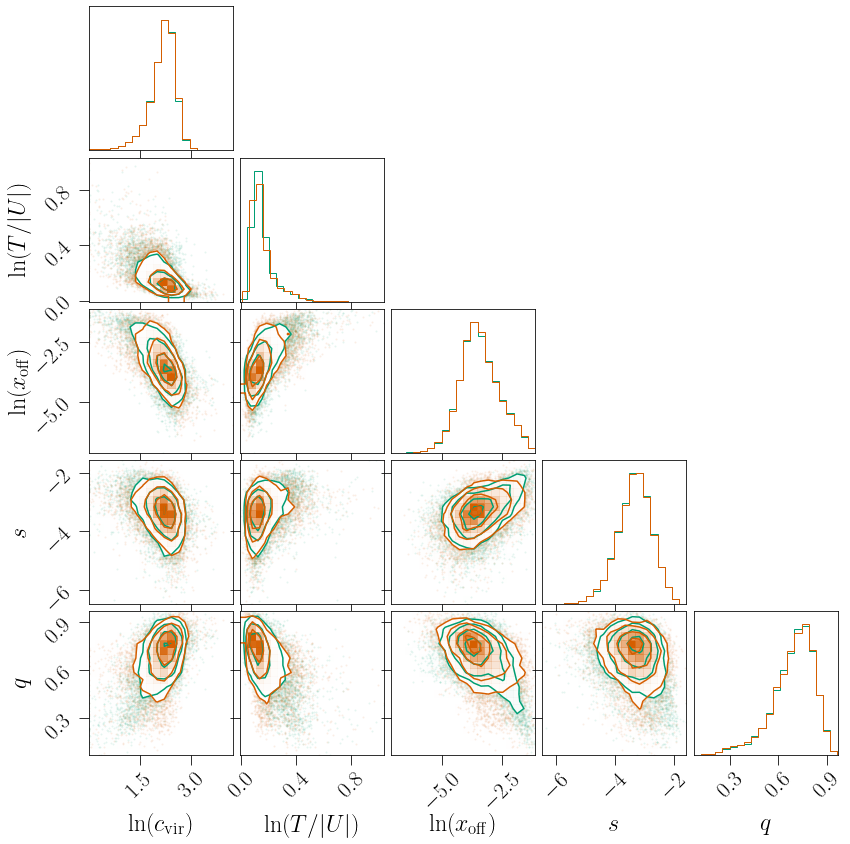

In [15]:
# only alpha as features
model = joint_models['multi_gaussian_alpha']
y_samples = model.sample(alphas, 1).reshape(-1, 5)
y_true = np.hstack([cvir.reshape(-1, 1), eta.reshape(-1, 1), xoff.reshape(-1, 1), spin.reshape(-1, 1),
                   q.reshape(-1, 1)])

# quantile transform each for plotting purposes (basically mean centering)
y1 = np.hstack([np.log(y_true[:, :4]), y_true[:, 4].reshape(-1, 1)])
y2 = np.hstack([np.log(y_samples[:, :4]), y_samples[:, 4].reshape(-1, 1)])


labels = ['$\\ln(c_{\\rm vir})$', '$\\ln(T / |U|)$', '$\\ln(x_{\\rm off})$', '$s$', '$q$']
fig = corner.corner(y1, labels=labels, max_n_ticks=3, color='C1', labelpad=0.1) # green = true
fig = corner.corner(y2, labels=labels, max_n_ticks=3, fig=fig, color='C2', labelpad=0.1) # orange = samples


## Only test data

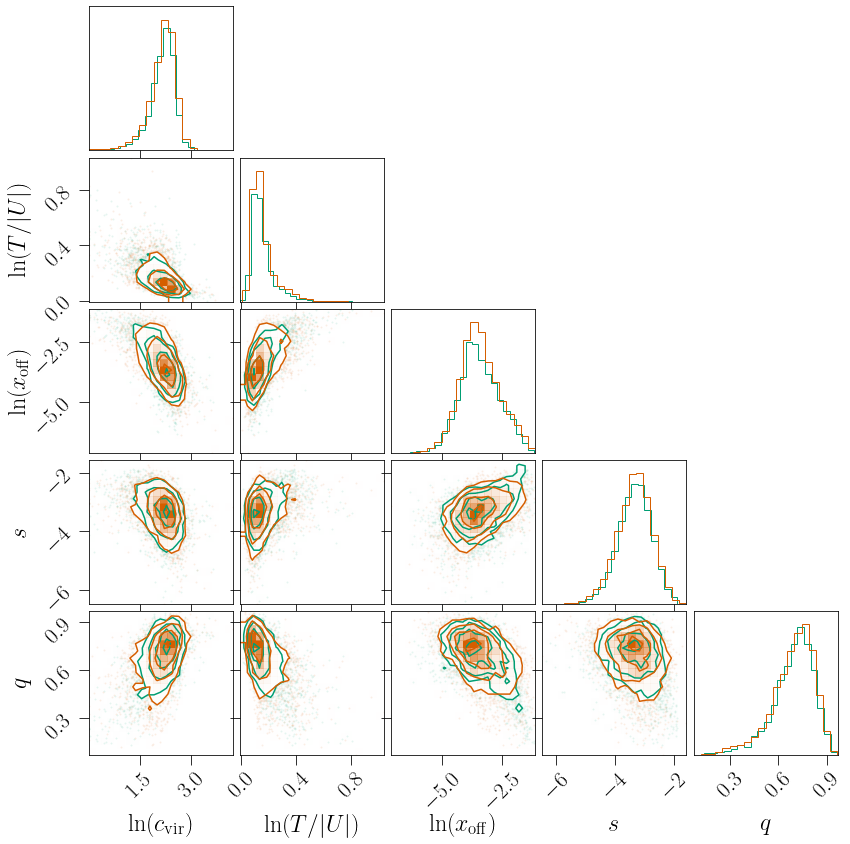

In [16]:
# multi-gaussian approach should do the best.
model = joint_models['multi_gaussian_alpha']
y_samples = model.sample(alpha_test, 1).reshape(-1, 5)
y_true = np.hstack([cvir_test.reshape(-1, 1), eta_test.reshape(-1, 1), xoff_test.reshape(-1, 1), spin_test.reshape(-1, 1),
                   q_test.reshape(-1, 1)])

# quantile transform each for plotting purposes (basically mean centering)
y1 = np.hstack([np.log(y_true[:, :4]), y_true[:, 4].reshape(-1, 1)])
y2 = np.hstack([np.log(y_samples[:, :4]), y_samples[:, 4].reshape(-1, 1)])


labels = ['$\\ln(c_{\\rm vir})$', '$\\ln(T / |U|)$', '$\\ln(x_{\\rm off})$', '$s$', '$q$']
fig = corner.corner(y1, labels=labels, max_n_ticks=3, color='C1', labelpad=0.1) # green = true
fig = corner.corner(y2, labels=labels, max_n_ticks=3, fig=fig, color='C2', labelpad=0.1) # orange = samples

In [27]:
joint_models['multi_gaussian_alpha'].rho

array([[ 1.        , -0.63271878, -0.63906445, -0.38559033,  0.45286892,
        -0.69266223],
       [-0.63271878,  1.        ,  0.64133211,  0.33294224, -0.53703613,
         0.56891486],
       [-0.63906445,  0.64133211,  1.        ,  0.43838801, -0.4815613 ,
         0.44359726],
       [-0.38559033,  0.33294224,  0.43838801,  1.        , -0.2485488 ,
         0.29071718],
       [ 0.45286892, -0.53703613, -0.4815613 , -0.2485488 ,  1.        ,
        -0.37233619],
       [-0.69266223,  0.56891486,  0.44359726,  0.29071718, -0.37233619,
         1.        ]])